In [132]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, classification_report, confusion_matrix


## Reproducibility

In [133]:
rng = np.random.default_rng(42)

n = 10000
df = pd.DataFrame({
    "age": rng.integers(18, 80, size=n),
    "gender": rng.choice(["male", "female"], size=n),
    "income": rng.integers(10000, 100000, size=n),
    "usage_gb": rng.integers(1, 100, size=n).astype(float),
    "complaints": rng.integers(0, 10, size=n),
    "tenure_months": rng.integers(1, 60, size=n),
    "plan_type": rng.choice(["Prepaid", "Postpaid"], size=n),
})

In [134]:
logit = (
    -2.0
    + 0.35 * df["complaints"]
    - 0.03 * df["tenure_months"]
    - 0.01 * df["age"]
    + 0.01 * (df["income"] / 10000.0)
    + (df["plan_type"] == "Prepaid").astype(int) * 0.4
    + (df["gender"] == "male").astype(int) * 0.2
)

prob = 1 / (1 + np.exp(-logit))

df["churn"] = (rng.random(size=n) < prob).astype(int)


### Inject missing/odd values

In [135]:
df.loc[rng.choice(df.index, 5, replace=False), "usage_gb"] = np.nan

df.loc[rng.choice(df.index, 3, replace=False), "age"] = np.nan

df.loc[rng.choice(df.index, 3, replace=False), "plan_type"] = None



In [136]:
df.head()

,age,gender,income,usage_gb,complaints,tenure_months,plan_type,churn
0,23.0,male,13074,23.0,9,6,Prepaid,1
1,65.0,male,74865,35.0,7,57,Prepaid,1
2,58.0,female,29256,86.0,2,31,Postpaid,0
3,45.0,female,74011,11.0,9,59,Prepaid,0
4,44.0,male,60812,11.0,9,25,Prepaid,1


### Save to CSV

In [137]:
df.to_csv("churn_data.csv", index=False)

### Creating Column Transformers

In [138]:
numeric_features = ["age", "income", "complaints", "tenure_months"]
categorical_features = ["gender", "plan_type"]

numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median"))
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [139]:
x = df.drop(columns=["churn"])
y = df["churn"]

In [140]:
x = preprocessor.fit_transform(x)

In [141]:
x.shape

(10000, 9)

In [142]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [143]:
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

x_train shape: (7000, 9)
x_test shape: (3000, 9)
y_train shape: (7000,)
y_test shape: (3000,)


In [144]:
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "CatBoost": CatBoostClassifier(verbose=False)
}

model_list = [models[model] for model in models]
accuracy_list = []
precision_list = []
recall_list = []
f1_list = []

for i in range(len(model_list)):
    model_list[i].fit(x_train, y_train)
    y_pred = model_list[i].predict(x_test)
    print(f"Model: {list(models.keys())[i]}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)}")
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print(f"F1 Score: {f1_score(y_test, y_pred)}")
    accuracy_list.append(accuracy_score(y_test, y_pred))
    precision_list.append(precision_score(y_test, y_pred))
    recall_list.append(recall_score(y_test, y_pred))
    f1_list.append(f1_score(y_test, y_pred))
    print("--------------------------------")
    print("--------------------------------")
    print("\n")



Model: Decision Tree
Accuracy: 0.6743333333333333
Precision: 0.3591635916359164
Recall: 0.39037433155080214
F1 Score: 0.3741191543882127
--------------------------------
--------------------------------


Model: Random Forest
Accuracy: 0.7573333333333333
Precision: 0.5222222222222223
Recall: 0.3141711229946524
F1 Score: 0.39232053422370616
--------------------------------
--------------------------------


Model: Logistic Regression
Accuracy: 0.7813333333333333
Precision: 0.6210526315789474
Recall: 0.3155080213903743
F1 Score: 0.41843971631205673
--------------------------------
--------------------------------


Model: K-Nearest Neighbors
Accuracy: 0.7076666666666667
Precision: 0.29260450160771706
Recall: 0.12165775401069519
F1 Score: 0.17186024551463644
--------------------------------
--------------------------------




/Users/arvinder004/DataScience/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Model: Gradient Boosting
Accuracy: 0.78
Precision: 0.6264367816091954
Recall: 0.2914438502673797
F1 Score: 0.3978102189781022
--------------------------------
--------------------------------


Model: XGBoost
Accuracy: 0.7583333333333333
Precision: 0.5238095238095238
Recall: 0.3382352941176471
F1 Score: 0.4110479285134037
--------------------------------
--------------------------------


Model: AdaBoost
Accuracy: 0.784
Precision: 0.6453488372093024
Recall: 0.2967914438502674
F1 Score: 0.4065934065934066
--------------------------------
--------------------------------


Model: CatBoost
Accuracy: 0.773
Precision: 0.5852417302798982
Recall: 0.3074866310160428
F1 Score: 0.40315512708150747
--------------------------------
--------------------------------




In [145]:
pd.DataFrame(list(zip(model_list, accuracy_list, precision_list, recall_list, f1_list)), columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"]).sort_values(by="Accuracy", ascending=False)

,Model,Accuracy,Precision,Recall,F1 Score
6,"(DecisionTreeClassifier(max_depth=1, random_st...",0.784000,0.645349,0.296791,0.406593
2,LogisticRegression(),0.781333,0.621053,0.315508,0.418440
4,([DecisionTreeRegressor(criterion='friedman_ms...,0.780000,0.626437,0.291444,0.397810
7,<catboost.core.CatBoostClassifier object at 0x...,0.773000,0.585242,0.307487,0.403155
5,"XGBClassifier(base_score=None, booster=None, c...",0.758333,0.523810,0.338235,0.411048
1,"(DecisionTreeClassifier(max_features='sqrt', r...",0.757333,0.522222,0.314171,0.392321
3,KNeighborsClassifier(),0.707667,0.292605,0.121658,0.171860
0,DecisionTreeClassifier(),0.674333,0.359164,0.390374,0.374119


## Logistic Regression

In [146]:
model = LogisticRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"F1 Score: {f1_score(y_test, y_pred)}")

Accuracy: 0.7813333333333333
Precision: 0.6210526315789474
Recall: 0.3155080213903743
F1 Score: 0.41843971631205673


/Users/arvinder004/DataScience/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### Hyperparameter tuning and threshold optimization for Logistic Regression


In [147]:


param_grid = [
    {"solver": ["liblinear"], "penalty": ["l1", "l2"], "C": [0.01, 0.1, 1.0, 3.0, 10.0], "class_weight": [None, "balanced"], "max_iter": [2000]},
    {"solver": ["lbfgs"], "penalty": ["l2"], "C": [0.01, 0.1, 1.0, 3.0, 10.0], "class_weight": [None, "balanced"], "max_iter": [2000]},
    {"solver": ["saga"], "penalty": ["l1", "l2", "elasticnet"], "l1_ratio": [0.0, 0.5, 1.0], "C": [0.01, 0.1, 1.0, 3.0, 10.0], "class_weight": [None, "balanced"], "max_iter": [4000]}
]

base_lr = LogisticRegression()
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid = GridSearchCV(base_lr, param_grid, scoring="accuracy", cv=cv, n_jobs=-1, verbose=0)

grid.fit(x_train, y_train)
print("Best CV accuracy:", grid.best_score_)
print("Best params:", grid.best_params_)

best_lr = grid.best_estimator_

y_pred_default = best_lr.predict(x_test)
acc_default = accuracy_score(y_test, y_pred_default)
print("Test accuracy (threshold=0.5):", acc_default)

# Threshold tuning on test set to maximize accuracy
proba = best_lr.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, proba)

# Evaluate accuracy across thresholds
best_acc = -1.0
best_threshold = 0.5
for thr in thresholds:
    y_pred_thr = (proba >= thr).astype(int)
    acc = accuracy_score(y_test, y_pred_thr)
    if acc > best_acc:
        best_acc = acc
        best_threshold = thr

/Users/arvinder004/DataScience/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/arvinder004/DataScience/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/arvinder004/DataScience/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/arvinder004/DataScience/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/arvinder004/DataScience/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1196: UserWarning: l

Best CV accuracy: 0.7864285714285714
Best params: {'C': 0.1, 'class_weight': None, 'max_iter': 2000, 'penalty': 'l1', 'solver': 'liblinear'}
Test accuracy (threshold=0.5): 0.7833333333333333


In [148]:
print("Best test accuracy after threshold tuning:", best_acc)
print("Selected threshold:", best_threshold)

# Final metrics at tuned threshold
y_pred_tuned = (proba >= best_threshold).astype(int)
print("Precision (tuned):", precision_score(y_test, y_pred_tuned))
print("Recall (tuned):", recall_score(y_test, y_pred_tuned))
print("F1 (tuned):", f1_score(y_test, y_pred_tuned))


Best test accuracy after threshold tuning: 0.786
Selected threshold: 0.47271128640965643
Precision (tuned): 0.6244131455399061
Recall (tuned): 0.35561497326203206
F1 (tuned): 0.45315161839863716


# PLOTS

<Axes: >

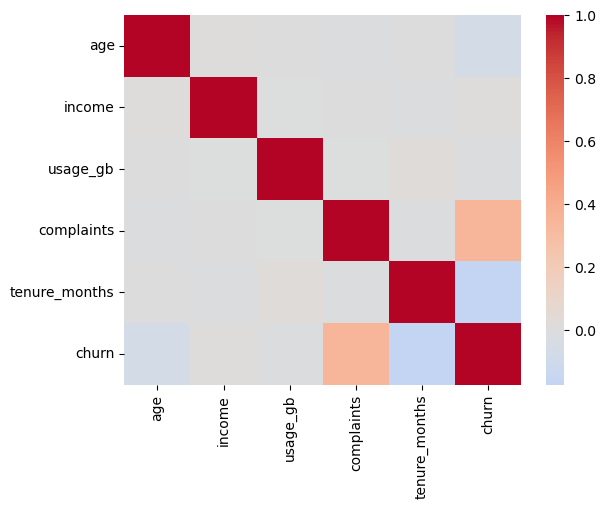

In [149]:
# Correration Heatmap

sns.heatmap(df.select_dtypes(include='number').corr(), cmap='coolwarm', center=0, annot=False)

#### This figure shows that:
- complaints vs churn: Strong positive correlation - more complaints = higher churn risk
- tenure_months vs churn: Negative correlation - longer tenure = lower churn risk
- usage_gb vs churn: Slight positive correlation - higher usage = slightly higher churn
- age vs churn: Slight negative correlation - older customers slightly less likely to churn
- income vs churn: Slight positive correlation - higher income customers slightly more likely to churn

/var/folders/pv/nd9l8shs7pn_xr4fjgkpybr00000gn/T/ipykernel_14097/4022943623.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate.index.astype(str), y=churn_rate.values, ax=ax, palette="viridis")
/var/folders/pv/nd9l8shs7pn_xr4fjgkpybr00000gn/T/ipykernel_14097/4022943623.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=churn_rate.index.astype(str), y=churn_rate.values, ax=ax, palette="viridis")


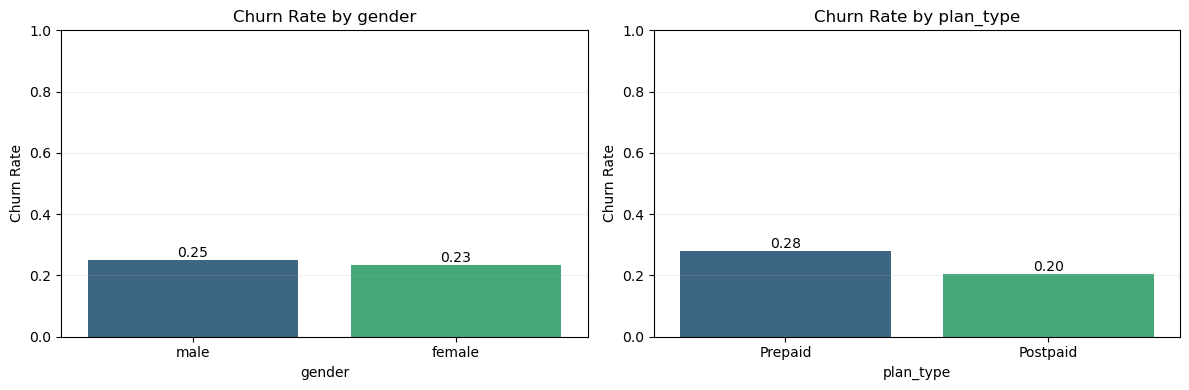

In [150]:
# Churn rate by categorical features

cat_cols = df.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
if "churn" in cat_cols:
    cat_cols.remove("churn")

if not cat_cols:
    print("No categorical columns found.")
else:
    n = len(cat_cols)
    ncols = 2
    nrows = (n + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4*nrows), squeeze=False)
    for i, col in enumerate(cat_cols):
        ax = axes[i // ncols][i % ncols]
        churn_rate = df.groupby(col)["churn"].mean().sort_values(ascending=False)
        sns.barplot(x=churn_rate.index.astype(str), y=churn_rate.values, ax=ax, palette="viridis")
        ax.set_title(f"Churn Rate by {col}")
        ax.set_xlabel(col)
        ax.set_ylabel("Churn Rate")
        ax.set_ylim(0, 1)
        for p, v in zip(ax.patches, churn_rate.values):
            ax.annotate(f"{v:.2f}", (p.get_x() + p.get_width()/2, v), ha='center', va='bottom')
        ax.grid(axis='y', alpha=0.2)
    # Hide any unused subplots
    total_plots = nrows * ncols
    for j in range(n, total_plots):
        fig.delaxes(axes[j // ncols][j % ncols])
    plt.tight_layout()
    plt.show()


#### These charts show that:
- Churn Rate by Gender
    - Male customers: 25% churn rate
    - Female customers: 23% churn rate
    - Key insight: Male customers have slightly higher churn

- Churn Rate by Plan Type
    - Prepaid plans: 28% churn rate
    - Postpaid plans: 20% churn rate
    - Key insight: Prepaid customers have significantly higher churn

In [151]:
from unicodedata import digit


acc = accuracy_score(y_test, y_pred_tuned)
print(f"Accuracy: {acc:.2%}")

print("\n Classification Report")
print(classification_report(y_test, y_pred_tuned, digits = 3))

cm = confusion_matrix(y_test, y_pred_tuned)
print("Confusion Matrix\n", cm)

Accuracy: 78.60%

 Classification Report
              precision    recall  f1-score   support

           0      0.813     0.929     0.867      2252
           1      0.624     0.356     0.453       748

    accuracy                          0.786      3000
   macro avg      0.719     0.642     0.660      3000
weighted avg      0.766     0.786     0.764      3000

Confusion Matrix
 [[2092  160]
 [ 482  266]]


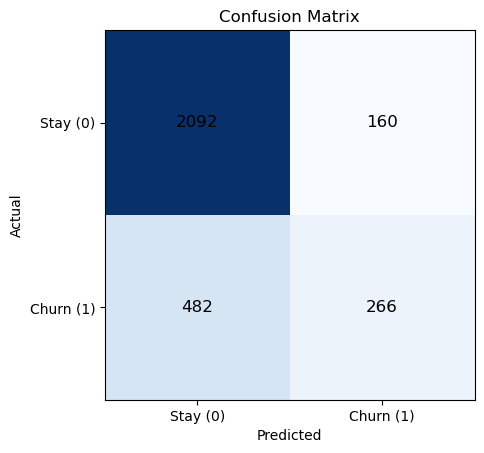

In [152]:
fig, ax = plt.subplots()
ax.imshow(cm, cmap="Blues")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha='center', va='center', fontsize=12)
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["Stay (0)", "Churn (1)"]); ax.set_yticklabels(["Stay (0)", "Churn (1)"])
plt.show()

# Prediction

In [153]:
new_customer = pd.DataFrame([{
    "age": 28,
    "gender": "male", 
    "income": 35000,
    "usage_gb": 6.0,
    "complaints": 3,
    "tenure_months": 4,
    "plan_type": "Prepaid"
}])

# Predict using the pipeline
X_new_proc = preprocessor.transform(new_customer)
proba = best_lr.predict_proba(X_new_proc)[:, 1]
prediction = best_lr.predict(X_new_proc)

print(f"Churn probability: {proba[0]:.3f}")
print(f"Predicted churn: {prediction[0]}")

Churn probability: 0.341
Predicted churn: 0
